In [4]:
import ast  # 用于解析字符串形式的列表
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel

# 1. 修正数据集类
class Flickr30kDataset(Dataset):
    def __init__(self, annotations_path, image_dir, processor, split='train'):
        self.image_dir = image_dir
        self.processor = processor
        
        # 加载CSV文件
        df = pd.read_csv(annotations_path)
        
        # 过滤指定split的数据
        self.df = df[df['split'] == split]
        
        # 解析raw列中的caption列表
        self.captions = []
        self.image_ids = []
        for _, row in self.df.iterrows():
            # 将字符串形式的列表转换为实际列表
            caption_list = ast.literal_eval(row['raw'])
            for caption in caption_list:
                self.captions.append(caption)
                self.image_ids.append(row['filename'])  # 使用filename作为图像ID

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        caption = self.captions[idx]
        
        # 加载图像 - 注意路径构造
        image_path = f"{self.image_dir}/flickr30k-images/{image_id}"
        image = Image.open(image_path)
        
        # 处理器处理
        inputs = self.processor(
            text=caption,
            images=image,
            return_tensors="pt",
            padding=True,
            truncation=True
        )
        
        # 移除batch维度
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs

# 2. 初始化处理器和预训练模型
model_name = "/mnt/workspace/ai/models/clip-vit-base/"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# 3. 创建数据集 - 使用实际split列
image_dir = "/mnt/workspace/ai/datasets/flickr30k_dataset"
annotations_path = f"{image_dir}/flickr_annotations_30k.csv"

train_dataset = Flickr30kDataset(annotations_path, image_dir, processor, split='train')
val_dataset = Flickr30kDataset(annotations_path, image_dir, processor, split='val')
test_dataset = Flickr30kDataset(annotations_path, image_dir, processor, split='test')  # 如果有测试集

# 4. 创建数据加载器
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

In [5]:

# 1. 数据集基本信息
print("=== 数据集基本信息 ===")
print(f"训练集样本数: {len(train_dataset)}")
print(f"验证集样本数: {len(val_dataset)}")
print(f"测试集样本数: {len(test_dataset)}")
print(f"总样本数: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")

=== 数据集基本信息 ===
训练集样本数: 100
验证集样本数: 0
测试集样本数: 0
总样本数: 100


In [6]:
#3. 微调模型

from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence

# 检查设备
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 自定义collate函数对齐
def clip_collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    input_ids = [item["input_ids"].squeeze(0) for item in batch]
    attention_mask = [item["attention_mask"].squeeze(0) for item in batch]
    
    # 填充文本序列
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    
    # 堆叠图像张量
    pixel_values_stacked = torch.stack(pixel_values)
    
    return {
        "pixel_values": pixel_values_stacked,
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded
    }

# 重新创建数据加载器
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16, collate_fn=clip_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=clip_collate_fn)

# 3. 微调模型
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
train_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        # 移到设备 - 注意现在batch是字典
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        # 前向传播 - 显式传递参数
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_loss=False  # 我们自己计算损失
        )
        
        # 计算对比损失
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text
        
        # 创建目标矩阵 (对角线为1)
        batch_size = logits_per_image.shape[0]
        targets = torch.eye(batch_size).to(device)
        
        # 计算交叉熵损失
        loss_img = torch.nn.functional.cross_entropy(logits_per_image, targets)
        loss_txt = torch.nn.functional.cross_entropy(logits_per_text, targets)
        loss = (loss_img + loss_txt) / 2

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Batch {batch_idx} | Loss: {loss.item():.4f}")
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Complete | Avg Loss: {avg_loss:.4f}")

# 保存微调后的模型
# torch.save(model.state_dict(), "clip_finetuned_flickr30k.pt")

Using device: cpu
Epoch 1/3 | Batch 0 | Loss: 0.5600
Epoch 1 Complete | Avg Loss: 1.1699
Epoch 2/3 | Batch 0 | Loss: 1.2703
Epoch 2 Complete | Avg Loss: 0.8662
Epoch 3/3 | Batch 0 | Loss: 1.2513
Epoch 3 Complete | Avg Loss: 0.8052


In [19]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# 设置为评估模式
model.eval()

# 预先计算验证集所有图像特征
custom_image_paths = [
    "/mnt/workspace/ai/datasets/flickr30k_dataset/flickr30k-images/100197432.jpg", 
    "/mnt/workspace/ai/datasets/flickr30k_dataset/flickr30k-images/1002674143.jpg", 
    "/mnt/workspace/ai/datasets/flickr30k_dataset/flickr30k-images/1003420127.jpg", 
    "/mnt/workspace/ai/datasets/flickr30k_dataset/flickr30k-images/1002674143.jpg", 
    "/mnt/workspace/ai/datasets/flickr30k_dataset/flickr30k-images/997338199.jpg", 
]
image_features_list = []

# 确保模型在设备上且为评估模式
model.eval()

for path in custom_image_paths:
    try:
        img = Image.open(path).convert("RGB")
        # 使用处理器处理图像
        inputs = processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            features = model.get_image_features(**inputs)
        image_features_list.append(features.cpu())
        print(f"已处理: {path}")
    except Exception as e:
        print(f"处理 {path} 时出错: {str(e)}")

# 合并所有图像特征
if image_features_list:
    image_features = torch.cat(image_features_list, dim=0)
    print(f"图像特征库形状: {image_features.shape}")
else:
    print("警告: 没有成功处理的图像!")
    image_features = torch.tensor([])

image_paths = custom_image_paths

已处理: /mnt/workspace/ai/datasets/flickr30k_dataset/flickr30k-images/100197432.jpg
已处理: /mnt/workspace/ai/datasets/flickr30k_dataset/flickr30k-images/1002674143.jpg
已处理: /mnt/workspace/ai/datasets/flickr30k_dataset/flickr30k-images/1003420127.jpg
已处理: /mnt/workspace/ai/datasets/flickr30k_dataset/flickr30k-images/1002674143.jpg
已处理: /mnt/workspace/ai/datasets/flickr30k_dataset/flickr30k-images/997338199.jpg
图像特征库形状: torch.Size([5, 512])


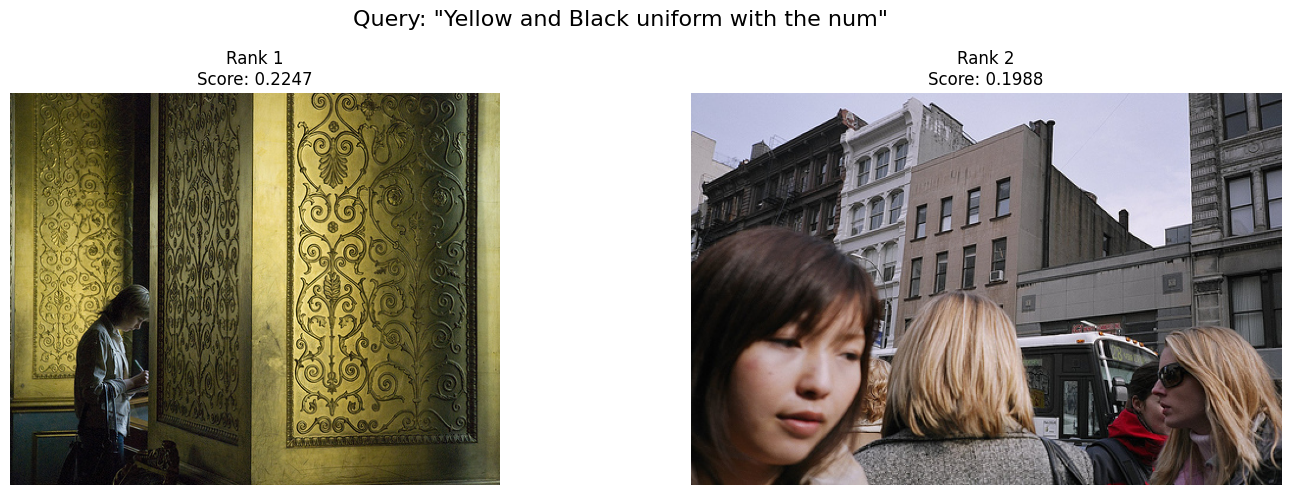

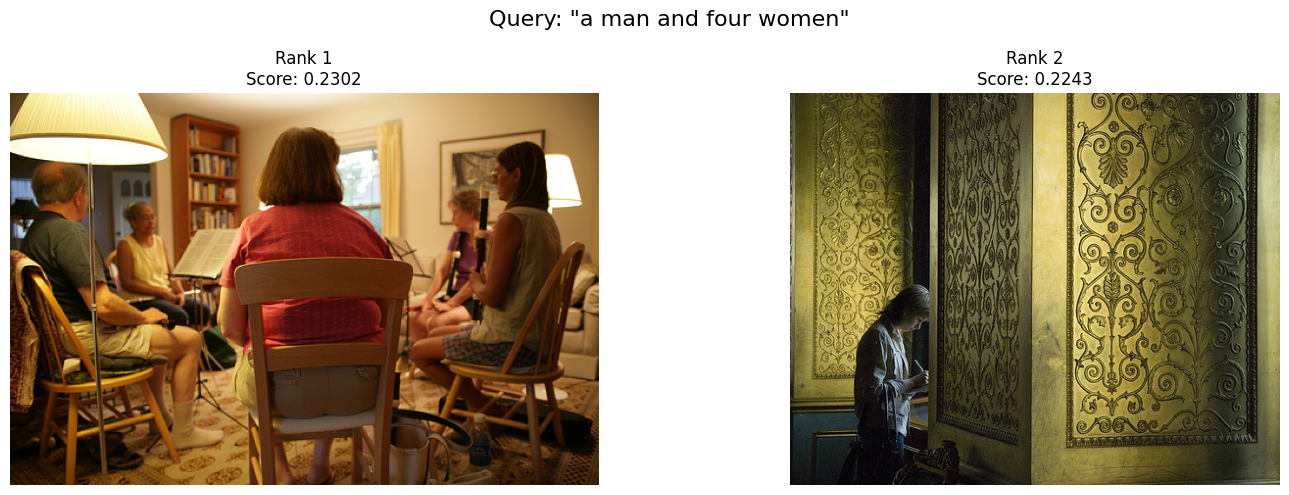

In [21]:
# 文本到图像搜索函数
def text_to_image_search(query_text, top_k=3):
    if image_features.nelement() == 0:
        print("错误: 图像特征库为空!")
        return
    
    # 处理输入文本
    inputs = processor(
        text=query_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=77  # CLIP的标准最大长度
    ).to(device)
    
    # 提取文本特征
    with torch.no_grad():
        text_features = model.get_text_features(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )
    
    # 归一化特征 (重要!)
    image_features_norm = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features_norm = text_features / text_features.norm(dim=-1, keepdim=True)
    
    # 计算相似度 (余弦相似度)
    similarity_scores = (image_features_norm.to(device) @ text_features_norm.T).squeeze(1)
    
    # 获取最相似的top_k个索引
    top_indices = similarity_scores.argsort(descending=True)[:top_k]
    
    # 显示结果
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_indices):
        img = Image.open(image_paths[idx])
        plt.subplot(1, top_k, i+1)
        plt.imshow(img)
        plt.title(f"Rank {i+1}\nScore: {similarity_scores[idx]:.4f}")
        plt.axis('off')
    plt.suptitle(f'Query: "{query_text}"', fontsize=16)
    plt.tight_layout()
    plt.show()

# 示例查询
text_to_image_search("Yellow and Black uniform with the num", top_k=2)
text_to_image_search("a man and four women", top_k=2)